In [100]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import neural_network as nn
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
import random
random.seed(42)
np.random.seed(42)

In [74]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
train_x, train_y = train.drop(['label'], axis=1), train['label']

In [76]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, stratify=train_y, random_state=42, test_size=0.2)

In [77]:
mm = StandardScaler()
train_x = np.array(mm.fit_transform(train_x))
valid_x = np.array(mm.transform(valid_x))
test = np.array(mm.transform(test))
train_y = np.array(train_y)
valid_y = np.array(valid_y)

In [78]:
train_x.shape, valid_x.shape, test.shape

((33600, 784), (8400, 784), (28000, 784))

In [79]:
class MLPClassifier:
    EPSILON = 10**-8

    def __init__(self, layers=[784,200,50,10], Weight_init='random', optimizer='gradient_descent', 
                 activation_function='tanh', Num_epochs=200, loss='cross_entropy', learning_rate=1e-5, 
                 Batch_size=64, Regularization=None, verbose=0, lambd=0.7, tol=1e-4, batch_norm=False):
        weight_fn = {'random' : self.random, 'he':self.He, 'xavier':self.Xavier}
        loss_fn = {'cross_entropy': self.cross_entropy_loss}
        act_fn = {'relu': [self.relu, self.relu_grad], 'leakyrelu': [self.leakyrelu, self.leakyrelu_grad], 'tanh': [self.tanh, self.tanh_grad], 'sigmoid': [self.sigmoid, self.sigmoid_grad]}
        opt_fn = {'gradient_descent': self.gradient_descent, 'momentum': self.gradient_descent_with_momentum,'nag':self.NAG, 'adagrad': self.Adagrad, 'rmsprop': self.RMSProp, 'adam': self.Adam}
        reg_fn = {None: [lambda x: 0, lambda x, y: 0], 'L1': [self.L1, self.L1_grad], 'L2': [self.L2, self.L2_grad]}
        self.layers = layers
        self.n_layers = len(layers)
        self.weight_init = weight_fn[Weight_init]
        self.is_gd = optimizer=='gradient_descent'
        self.optimizer = opt_fn[optimizer]
        self.act = act_fn[activation_function]
        self.num_epochs = Num_epochs
        self.loss = loss_fn[loss]
        self.learning_rate = learning_rate
        self.batch_size = Batch_size
        self.regularization = reg_fn[Regularization]
        self.verbose = verbose
        self.lambd = lambd
        self.tol = tol
        self.batch_norm = batch_norm

    def init_weights(self):
        self.weights = [None]*(self.n_layers)
        self.momentum = [None]*(self.n_layers)
        self.G = [None]*(self.n_layers)
        for i in range(1, self.n_layers):
            # self.weights[i] = np.random.randn(self.layers[i], self.layers[i-1]) * 0.01
            self.momentum[i] = np.zeros((self.layers[i], self.layers[i-1]))
            self.G[i] = np.zeros((self.layers[i], self.layers[i-1]))
            self.weights[i] = self.weight_init((self.layers[i], self.layers[i-1]), i)

    def random(self, shape, l):
        return np.random.normal(0, 1, shape) * 0.01

    def He(self, shape, l):
        return np.random.normal(0, np.sqrt(2/self.layers[l-1]), shape)

    def Xavier(self, shape, l):
        return np.random.normal(0, np.sqrt(1/self.layers[l-1]), shape)

    def relu(self, Z):
        return np.where(Z > 0, Z, 0)
    
    def leakyrelu(self, Z):
        return np.where(Z > 0, Z, Z * 0.01)

    def tanh(self, Z):
        return np.tanh(Z)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        '''Numerically stable softmax
        '''
        exp = np.exp(Z - np.max(Z))
        return np.true_divide(exp, exp.sum(axis=0, keepdims=True))

    def relu_grad(self, A):
        return np.where(A > 0, 1, 0)
    
    def leakyrelu_grad(self, A):
        return np.where(A > 0, 1, 0.01)
    
    def tanh_grad(self, A):
        return 1 - A**2

    def sigmoid_grad(self, A):
        return A * (1 - A)

    def gradient_descent(self, grads, epoch):
        for i in range(1, self.n_layers):
            self.weights[i] = self.weights[i] - self.learning_rate * grads[i]

    def gradient_descent_with_momentum(self, grads, epoch):
        for i in range(1, self.n_layers):
            self.momentum[i] = 0.9 * self.momentum[i] - self.learning_rate * grads[i]
            self.weights[i] = self.weights[i] + self.momentum[i]

    def NAG(self, grads, epoch):
        for i in range(1,self.n_layers):
            x = 0.9*self.momentum[i]
            self.momentum[i] = x - self.learning_rate * (grads[i] + x)
            self.weights[i] = self.weights[i] + self.momentum[i]
    
    def Adagrad(self, grads, epoch):
        for i in range(1,self.n_layers):
            self.G[i] +=  np.square(grads[i])
            self.weights[i] = self.weights[i] - self.learning_rate * np.true_divide(grads[i], np.sqrt(self.G[i] + self.EPSILON))

    def RMSProp(self, grads, epoch):
        for i in range(1,self.n_layers):
            self.G[i] = 0.999 * self.G[i] + 0.001 * np.square(grads[i])
            self.weights[i] = self.weights[i] - self.learning_rate * np.true_divide(grads[i], np.sqrt(self.G[i] + self.EPSILON))
        
    def Adam(self, grads, epoch):
        for i in range(1,self.n_layers):
            # self.momentum[i] = np.true_divide(0.9 * self.momentum[i] + 0.1*grads[i], 1-0.9**epoch)
            # self.G[i] = np.true_divide(0.999 * self.G[i] + 0.001*np.square(grads[i]), 1-0.999**epoch)
            self.momentum[i] = 0.9 * self.momentum[i] + 0.1*grads[i]
            self.G[i] = 0.999 * self.G[i] + 0.001*np.square(grads[i])
            self.weights[i] = self.weights[i] - (self.learning_rate * self.momentum[i] / (np.sqrt(self.G[i]) + self.EPSILON))

    def L1(self, m):
        sum = 0
        for i in range(1, self.n_layers):
            sum += np.sum(np.abs(self.weights[i]))
        return self.lambd * sum / (2*m)

    def L1_grad(self, m, i):
        return np.where(self.weights[i] >= 0, 1, -1)

    def L2(self, m):
        sum = 0
        for i in range(1, self.n_layers):
            sum += np.sum(np.square(self.weights[i]))
        return self.lambd * sum / (2*m)

    def L2_grad(self, m, i):
        return (self.lambd/m) * self.weights[i]

    def cross_entropy_loss(self, AL, y):
        loss = -np.mean((y*np.log(AL.T + self.EPSILON))) * self.num_classes + self.regularization[0](y.shape[0])
        return loss

    def forward(self, X):
        cache = [None]*(self.n_layers)
        cache[0] = X.T
        for i in range(1, self.n_layers):
            Z = self.weights[i] @ cache[i-1]
            if i != self.n_layers -1:
                A = self.act[0](Z)
            else:
                A = self.softmax(Z)
            cache[i] = A
        return cache[self.n_layers-1], cache

    def backward(self, cache, loss, y):
        m = y.shape[0]
        grads = {}
        dZ = cache[self.n_layers-1] - y.T
        dW = (1 / m) * dZ @ cache[self.n_layers-2].T
        grads[self.n_layers-1] = dW
        dA_prev = self.weights[self.n_layers-1].T @ dZ
        for i in reversed(range(1, self.n_layers-1)):
            dZ = dA_prev * self.act[1](cache[i])
            dW = (1 / m) * (dZ @ cache[i-1].T) + self.regularization[1](m, i)
            dA_prev = self.weights[i].T @ dZ
            grads[i] = dW
        return grads
    
    def make_batches(self, X, y):
        if self.is_gd:
            self.batch_size = X.shape[0]
            
        shuffle_indices = np.random.permutation(X.shape[0])
        X = X[shuffle_indices]
        y = y[shuffle_indices]
        batches = []
        for i in range(0, X.shape[0], self.batch_size):
            if i + self.batch_size <= X.shape[0]:
                xb, yb = X[i: i + self.batch_size], y[i: i + self.batch_size]
                if self.batch_norm:
                    xb = self.batch_normalization(xb)
                batches.append((xb, yb))
            else:
                xb, yb = X[i:], y[i:]
                if self.batch_norm:
                    xb = self.batch_normalization(xb)
                batches.append((xb, yb))
        return batches

    def batch_normalization(self, batch):
        batch_mean = np.mean(batch, axis=0)
        batch_var = np.var(batch, axis=0)
        batch_norm = (batch - batch_mean) / np.sqrt(batch_var + self.EPSILON)
        return batch_norm

    def fit(self, X, y, X_val=None, y_val=None):
        #Adding another input dimention for bias
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        self.layers[0] += 1

        self.num_classes = len(np.unique(y))
        y = self.one_hot_encode(self.num_classes, y)
        if X_val is not None:
            X_val = np.hstack((X_val, np.ones((X_val.shape[0], 1))))
            y_val = self.one_hot_encode(self.num_classes,y_val)

        batches = self.make_batches(X, y)

        self.init_weights()

        train_loss = []
        valid_loss = []
        stop = 0
        epochs = self.num_epochs
        if epochs == 'auto':
            epochs = 200
        for epoch in range(1, epochs+1):
            for xb, yb in batches:
                AL, cache = self.forward(xb)
                loss = self.loss(AL, yb)
                grads = self.backward(cache, loss, yb)
                self.optimizer(grads, epoch)

            loss = self.loss(self.forward(X)[0], y)
            train_loss.append(loss)
            if X_val is not None:
                val_loss = self.loss(self.forward(X_val)[0], y_val)
                valid_loss.append(val_loss)
            
            if self.verbose == 1 and epoch%1 == 0:
                print(f'Epoch: {epoch}    Loss: {loss}', end='')
                if X_val is not None:
                    print(f'    Val Loss: {val_loss}', end='')
                print()
            if math.isnan(train_loss[-1]):
                print('NaN loss')
                break
            if self.num_epochs == 'auto' and epoch > 1:
                if stop == 10:
                    self.num_epochs = epoch
                    print(f'Training loss did not improve more than tol={self.tol} for 10 consecutive epochs. Stopping. (Iter={epoch})')
                    break
                elif train_loss[-2] - train_loss[-1] < self.tol:
                    stop += 1
                else:
                    stop = 0
        if self.num_epochs == 'auto':
            self.num_epochs = 200
            
        if self.verbose == 1:
            fig = plt.figure(figsize=(12,8))
            plt.plot(range(self.num_epochs), train_loss, label='Training Loss')
            plt.plot(range(self.num_epochs), valid_loss, label='Validation Loss')
            plt.legend()
            plt.show()

        if self.verbose == 2:
            return train_loss, valid_loss

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=0)

    def predict_proba(self, X):
        if X.shape[1] < self.layers[0]:
            X = np.hstack((X, np.ones((X.shape[0], 1))))
        return self.forward(X)[0]
    
    @staticmethod
    def one_hot_encode(num_classes, y):
        one_hot_encoded_y = np.eye(num_classes)[y.reshape(-1)]
        return one_hot_encoded_y

    def get_params(self):
        return np.array(self.weights[1:])

    def score(self, X, y):
        '''X: a numpy array of shape (num_examples, num_features): This 2d matrix contains the
        complete dataset.
        Y: a numpy array of shape (num_examples): This array contains the classification labels
        of the task.
        Returns
        -------
        (float) Classification accuracy given X and y.
        '''
        return np.mean(self.predict(X) == y)

In [99]:
%%time
mlp = MLPClassifier(layers = [784, 1500, 400, 10], 
                    learning_rate = 1e-4,
                    activation_function = 'relu', 
                    Num_epochs = 20, 
                    optimizer = 'adam',
                    Weight_init = 'he',
                    Batch_size = 50,
                    verbose = 1,
                    Regularization = 'L2',
                    lambd = 0.1)
mlp.fit(train_x, train_y, valid_x, valid_y)
print(f'Training Accuracy: {mlp.score(train_x, train_y) * 100}%')
print(f'Validation Accuracy: {mlp.score(valid_x, valid_y) * 100}%')

Epoch: 1    Loss: 0.09478031833670708    Val Loss: 0.16134982830471675


KeyboardInterrupt: 

In [104]:
skl_mlp = nn.MLPClassifier(hidden_layer_sizes=(200), learning_rate_init=1e-4, batch_size=50, verbose=1)
skl_mlp.fit(train_x, train_y)
skl_mlp.score(valid_x, valid_y)

Iteration 1, loss = 0.68034603
Iteration 2, loss = 0.27260630
Iteration 3, loss = 0.20067822
Iteration 4, loss = 0.16133228
Iteration 5, loss = 0.13446849
Iteration 6, loss = 0.11535652
Iteration 7, loss = 0.09989323
Iteration 8, loss = 0.08744921
Iteration 9, loss = 0.07659790
Iteration 10, loss = 0.06741799
Iteration 11, loss = 0.05962311
Iteration 12, loss = 0.05243101
Iteration 13, loss = 0.04654904
Iteration 14, loss = 0.04109988
Iteration 15, loss = 0.03635761
Iteration 16, loss = 0.03235432
Iteration 17, loss = 0.02857143
Iteration 18, loss = 0.02534549
Iteration 19, loss = 0.02236170
Iteration 20, loss = 0.01986047
Iteration 21, loss = 0.01769646
Iteration 22, loss = 0.01556970
Iteration 23, loss = 0.01378690
Iteration 24, loss = 0.01231882
Iteration 25, loss = 0.01086343
Iteration 26, loss = 0.00962556
Iteration 27, loss = 0.00859896
Iteration 28, loss = 0.00761313
Iteration 29, loss = 0.00683713
Iteration 30, loss = 0.00607390
Iteration 31, loss = 0.00542839
Iteration 32, los

0.9709523809523809

In [105]:
y_pred = skl_mlp.predict(valid_x)
print(classification_report(valid_y, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       826
           1       0.98      0.99      0.99       937
           2       0.97      0.98      0.97       835
           3       0.96      0.95      0.96       870
           4       0.97      0.97      0.97       814
           5       0.96      0.96      0.96       759
           6       0.98      0.99      0.98       828
           7       0.98      0.97      0.97       880
           8       0.98      0.95      0.96       813
           9       0.95      0.96      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



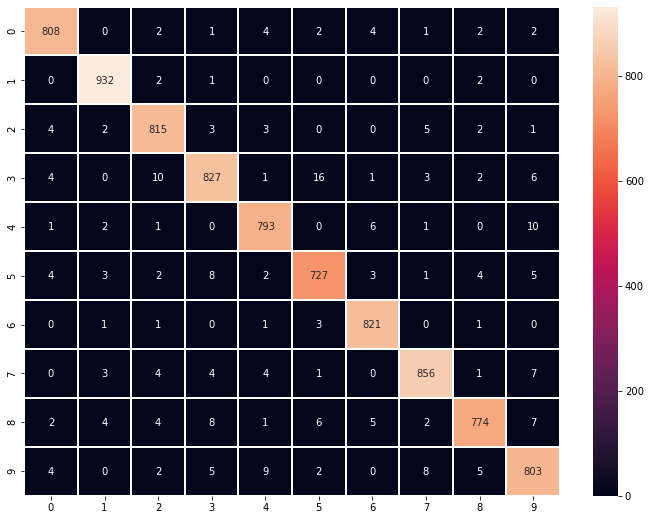

In [106]:
cm = confusion_matrix(valid_y, y_pred)
plt.figure(figsize=(12,9))
sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
plt.show()

In [108]:
submission = pd.read_csv('sample_submission.csv')
submission['Label'] = skl_mlp.predict(test)
submission.to_csv('mlp.csv', index=False)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
